In [ ]:
from IPython.display import clear_output
!pip install torch
!pip install torchvision
!pip install opencv-python
!pip install seaborn
!pip install matplotlib
!pip install cleverhans
!pip install cachetools
!pip install pandas
!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y
clear_output()

In [3]:
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import gc
from load_skin import load_skin_data

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
!pip install captum
!pip install cleverhans
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import GradientShap
from captum.attr import GuidedGradCam
from captum.attr import LimeBase
from captum.attr import KernelShap
from captum.attr import Occlusion
from captum.attr import visualization as viz
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent
)
clear_output()


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


NameError: name 'clear_output' is not defined

In [6]:
train_loader, val_loader = load_skin_data()

/root/load_skin.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)


In [5]:
model = torch.load('model/skin/model_skin.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


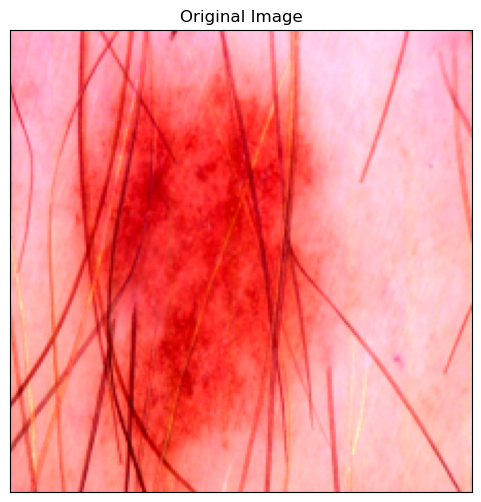

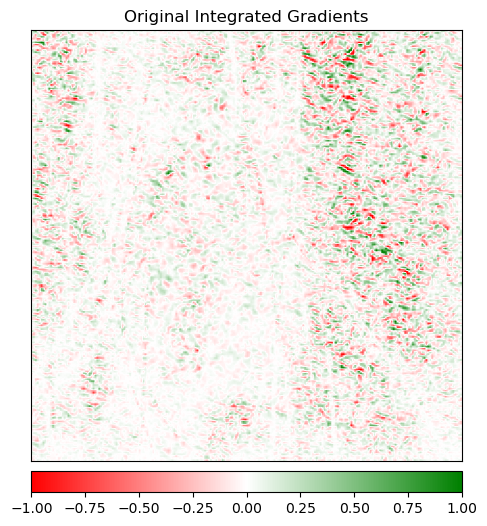

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


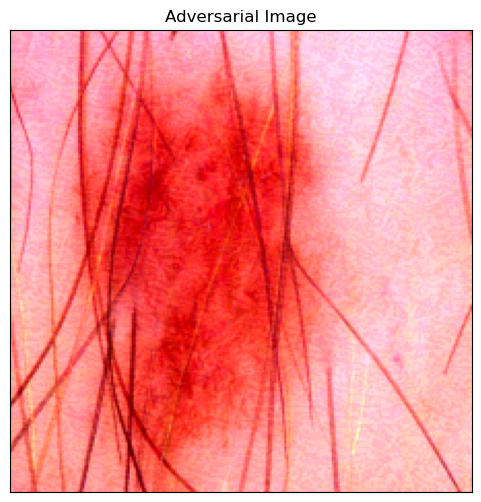

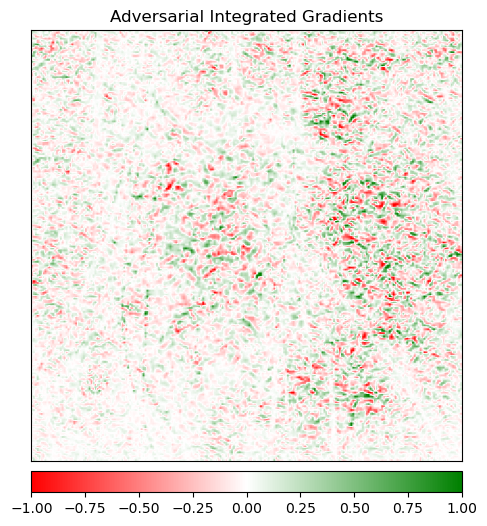

In [12]:
dataiter = iter(val_loader)
ind = 0

images, labels = next(dataiter)
input = images[ind].unsqueeze(0)
ig = IntegratedGradients(model)
attr_ig = ig.attribute(input, target=labels[ind],baselines=input * 0)
attr_ig1 = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
images_pgd = fast_gradient_method(model, input, 16/255, np.inf)
_, y_pred_pgd = model(images_pgd).max(1)
attr_pgd = ig.attribute(images_pgd, target=y_pred_pgd,baselines=input * 0)
attr_pgd1 = np.transpose(attr_pgd.squeeze().cpu().detach().numpy(), (1, 2, 0))
pgd_image = np.transpose((images_pgd[0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(attr_ig1, original_image, method="heat_map",sign="all",
                          show_colorbar=True, title="Original Integrated Gradients")

_ = viz.visualize_image_attr(None, pgd_image, 
                      method="original_image", title="Adversarial Image")

_ = viz.visualize_image_attr(attr_pgd1, pgd_image, method="heat_map",sign="all",
                          show_colorbar=True, title="Adversarial Integrated Gradients")


In [ ]:
def compute_iqr(attr):
    #inter-quartile range
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        score_75 = np.percentile(a, 75)
        score_25 = np.percentile(a, 25)
        score_qt = score_75 - score_25
        scores.append(score_qt)
    return scores

# attr_ig = attr_ig.sum(axis=1).cpu().detach().numpy()
# attr_pgd = attr_pgd.sum(axis=1).cpu().detach().numpy()
attr_ig = attr_ig.flatten()
print(attr_ig.shape)
# attr_ig = compute_iqr(attr_ig)
# attr_pgd = compute_iqr(attr_pgd)

plt.hist(attr_ig, label='clean', color='blue')
# plt.hist(attr_pgd, label='adv', alpha=0.7, color='red')
plt.legend()
plt.show()